In [59]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy.io
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec
print(400 + r_earth_const)

6778.1363


In [61]:

stop_time = 28730.0

num_of_objects = 3

meas_type = 3




if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_MultiObj.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['true_state']
true_state_all_times = mydict2['true_state_all_times'] #includes truth before & after measurements occur
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))


truth_xyz[:,:6] = truth_xyz[:,:6] * 1e-3 #convert to km
truth_xyz[:,-1] = truth_xyz[:,-1] * 1e9 #prep truth for filter used density magnitude/units

true_state_all_times[:,2:8] = true_state_all_times[:,2:8] * 1e-3 #convert to km
true_state_all_times[:,-1] = true_state_all_times[:,-1] * 1e9 #prep truth for filter used density magnitude/units

measurement_array[:, -1] = measurement_array[:, -1] * 1e-3 #convert to km



#calculate data time step using truth at all times
time_step = true_state_all_times[1,0] - true_state_all_times[0,0] #seconds


#specify initial index of filter simulation: anywhere from 1 ("time_step - 1") before to the first index
initial_sim_index = int(measurement_array[0,0]/time_step - 10) #initialize for time step before first measurement    
initial_sim_time = initial_sim_index * time_step
print(initial_sim_index, initial_sim_time)



print(measurement_array[0,0])
print('Initial measurement index: ', measurement_array[0,0]/time_step)
print('Initial simulation index: ', initial_sim_index)
#print(measurement_array[:50,:3])

(669, 6)
(669, 7)
2537 25370.0
25470.0
Initial measurement index:  2547.0
Initial simulation index:  2537


In [31]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids_moreRealistic.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4#1e-9 #1e-4****
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 


Shape of Vector of State/density Ensembles: (450, 37, 73)
0.00351022831235
0.00350940717465


In [32]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx


In [33]:

#EnKF specific functionality




def gen_ensemble(X_0, Bsqrt_cov, ensemble_size):
    
    X_0 = X_0.reshape(len(X_0), 1)
    
    ensemble = np.zeros((len(X_0), ensemble_size))
    
    for ii in range(ensemble_size):
        
        member = X_0 + np.dot(Bsqrt_cov, np.random.randn(len(X_0), 1))

        ensemble[:, ii] = member.reshape(len(X_0))
    
    return ensemble
    



In [34]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')


two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z

In [35]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp
    


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [36]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [37]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [38]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
X_full = X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot, density])
H_tilde = G.jacobian(X_full)
#print(H_tilde)
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [39]:



def calc_P_TU(X_mean, ensemble):
    
    dimension = len(X_mean)
    
    P_bar_sum = np.zeros((dimension, dimension))
    
    for ii in range(num_of_ensembles):

        X = ensemble[:, ii].reshape(dimension, 1)
        diff_X = X - X_mean
        P_bar_sum = P_bar_sum + np.dot(diff_X, diff_X.T)

    P_bar = P_bar_sum/(num_of_ensembles-1)

    return P_bar



In [40]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6 * num_of_objects
fullState_dimension = prob_dimension + density_dimension

single_obj_fullState_dim = 6 + density_dimension



X_ref = np.zeros((num_of_objects, 6))
P_bar_0 = np.zeros((num_of_objects, 7, 7))
X_RV_ensemble = np.zeros(())



for ii in range(num_of_objects):

    
    indices = np.where(true_state_all_times[:, 1] == (ii+1))[0] #find indices of truth that pertain to this object
    initial_RV = true_state_all_times[np.r_[indices],:][initial_sim_index] #select specificed initial index for sim 

    X_ref[ii,:] = np.array([initial_RV[2] + pos_perturbation, initial_RV[3] + pos_perturbation, initial_RV[4] \
                + pos_perturbation, initial_RV[5] + vel_perturbation, initial_RV[6] + vel_perturbation, \
                initial_RV[7] + vel_perturbation])
    
    
X_ref = X_ref.reshape(prob_dimension)


P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0_singleObj = [P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2]

P_bar_0_multiObj = np.tile(P_bar_0_singleObj, num_of_objects)
P_bar_0_multiObj = np.append(P_bar_0_multiObj, (1e-4)**2) #add density at the end
P_bar_0 = np.diag(P_bar_0_multiObj)




(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_RV_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_ensembles)
print(np.shape(X_RV_ensemble))


  


#for process noise
snc_sigma = 1e-5

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])


#reduced rank variable for number of eigvals
q = 39

    
print(X_ref)

(18, 450)
[ -3.753015906919020e+03  -5.356074535460995e+03  -1.713926386716531e+03
   6.132551338810440e+00  -3.240786829010667e+00  -3.311977873982675e+00
  -2.868250043062140e+03  -5.733864708580491e+03  -2.146005263500825e+03
   6.721939059180078e+00  -2.254557791631139e+00  -2.967984340454785e+00
  -1.923129007418327e+03  -5.970909365513601e+03  -2.522682153875068e+03
   7.144073559896914e+00  -1.223495411276810e+00  -2.555907919881859e+00]


In [41]:


indices = np.where(true_state_all_times[:,1] == 3)[0]  
true_state_all_times_thisObj = true_state_all_times[np.r_[indices,:]][initial_sim_index:initial_sim_index+2]
print(true_state_all_times_thisObj)
    

indices = np.where(true_state_all_times[:, 1] == 3)[0]
initial_RV = true_state_all_times[np.r_[indices],:][initial_sim_index]
#print(initial_RV)

#x_error_all = initial_RV - true_all_sim_times_thisObj


#true_all_sim_times_thisObj = true_state_all_times_thisObj\
                #[(initial_sim_index):(initial_sim_index+TU_array_length),:]

#times_all = true_state_all_times_thisObj[(initial_sim_index):(initial_sim_index+TU_array_length),0]/60


#x_error_all = X_mean_TU_list_EnKF[:TU_array_length,x_pos_index] - true_all_sim_times_thisObj[:,2]

[[  2.537000000000000e+04   3.000000000000000e+00  -1.923229007418327e+03
   -5.971009365513602e+03  -2.522782153875068e+03   7.143973559896915e+00
   -1.223595411276810e+00  -2.556007919881859e+00   5.005233146321240e-03]
 [  2.538000000000000e+04   3.000000000000000e+00  -1.851666753716851e+03
   -5.982859904353586e+03  -2.548178482662191e+03   7.168323188514258e+00
   -1.146487266292944e+00  -2.523203239788904e+00   4.987662993405145e-03]]


In [42]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

"""

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6
fullState_dimension = prob_dimension + density_dimension

X_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2] \
            + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation, \
            truth_xyz[0,5] + vel_perturbation])

                  
P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2, (1e-4)**2]) #(1e-4)**2


(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_RV_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_ensembles)
print(np.shape(X_RV_ensemble))


#for process noise
snc_sigma = 1e-5

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])


#reduced rank variable for number of eigvals
q = 39

    
print(X_ref)
"""

'\n\npos_perturbation = 100 * 1e-3 #km\nvel_perturbation = .1 * 1e-3 #km/s\n\ndensity_dimension = num_of_lat * num_of_lon\nprob_dimension = 6\nfullState_dimension = prob_dimension + density_dimension\n\nX_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2]             + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation,             truth_xyz[0,5] + vel_perturbation])\n\n                  \nP_sigma_pos = 100 * 1e-3 #km\nP_sigma_vel = .1 * 1e-3 #km/s\nP_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2,                    P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2, (1e-4)**2]) #(1e-4)**2\n\n\n(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors\nBsqrt_cov = V * np.sqrt(L)\nX_RV_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_ensembles)\nprint(np.shape(X_RV_ensemble))\n\n\n#for process noise\nsnc_sigma = 1e-5\n\n       \n                  \n#Defi

In [43]:
"""
X = X_ref
t_init = 0

X_array = np.zeros((3404, 6))
X_array[0,:] = X.reshape(6)

for ii in range(3403):
    
    time = t_init + 10

    #determine density to be used in propagation
    (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                        X[:3], day_of_month_init, hour_init_UT, month_init, \
                               year_init, omega_const, r_earth_const, lat_res, lon_res)
    
    densities = ensembles_of_density_grid[:, lat_grid_ticks, lst_grid_ticks]
    

    
    y0 = X
    density = np.mean(densities) * 1e-9

    integrator = ode(orbitpropogator_EnKF)
    integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
    integrator.set_f_params(density)
    integrator.set_initial_value(y0, t_init)
    integrator.integrate(time)
    X = integrator.y
    X_array[ii+1,:] = X.reshape(6)
    
    
    
    
    t_init = t_init + 10

"""

"\nX = X_ref\nt_init = 0\n\nX_array = np.zeros((3404, 6))\nX_array[0,:] = X.reshape(6)\n\nfor ii in range(3403):\n    \n    time = t_init + 10\n\n    #determine density to be used in propagation\n    (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init,                         X[:3], day_of_month_init, hour_init_UT, month_init,                                year_init, omega_const, r_earth_const, lat_res, lon_res)\n    \n    densities = ensembles_of_density_grid[:, lat_grid_ticks, lst_grid_ticks]\n    \n\n    \n    y0 = X\n    density = np.mean(densities) * 1e-9\n\n    integrator = ode(orbitpropogator_EnKF)\n    integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)\n    integrator.set_f_params(density)\n    integrator.set_initial_value(y0, t_init)\n    integrator.integrate(time)\n    X = integrator.y\n    X_array[ii+1,:] = X.reshape(6)\n    \n    \n    \n    \n    t_init = t_init + 10\n\n"

In [44]:
#KALMAN

def execute_enkf(obs_data, X_RV_ensemble, P, R, X_density_ensemble,\
                         prob_dimension, density_dimension, initial_sim_time, stop_index):
    
    #initializations
    Q_ECI = np.zeros((6,6)) #*******
    
    num_of_meas = np.shape(R)[0]
    X_7elem_mean_updated = np.sum(X_RV_ensemble, axis=1)/num_of_ensembles

    pre_fit_list = np.zeros((stop_index, num_of_meas))
    prefit_bounds_list = np.zeros((stop_index, num_of_meas))
    post_fit_list = np.zeros((stop_index, num_of_meas))

    P_list = np.zeros((stop_index, prob_dimension+1, prob_dimension+1))
    #P_full_list = np.zeros((21, fullState_dimension, fullState_dimension))
    X_7elem_mean_updated_list = np.zeros((stop_index, prob_dimension+1))
    X_7elem_mean_TU_list = np.zeros(((TU_array_length), prob_dimension+1))
    
    density_MSIS_array = np.zeros(stop_index)
    #est_density_grid_array = np.zeros((stop_index, num_of_lat, num_of_lon))

    
    X_distribution = np.zeros((prob_dimension, num_of_ensembles, stop_index))
    density_distribution = np.zeros((num_of_ensembles, stop_index))
    lat_lst_array = np.zeros((2, stop_index))
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))

    
    #for Reduced Rank
    dens_ens = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))
    X_ensemble[:prob_dimension, :] = X_RV_ensemble
    X_ensemble[prob_dimension:, :] = dens_ens

    #mean of X state & density state over ensemble
    X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
    P = calc_P_TU(X_mean, X_ensemble)
    
    eigvals, eigvecs = np.linalg.eig(P)
    eigvec_truncated = eigvecs[:, :q]
    eigvals_truncated = eigvals[:q]
    L = np.dot(eigvec_truncated, np.diag(np.sqrt(eigvals_truncated)))
    L = np.real(L)
    
    counter = 0
    
    
    t_init = initial_sim_time
    time = t_init + 10
    obsnum = 0
    
    
    while time < obs_data[stop_index,0]:
    #for obsnum in range(len(obs_data[:stop_index])):
    
            
        print(time)
           
         
        #reduced rank
        epsilon = .95 #number close to 1
        X_mean_wSigma_array = np.tile(X_mean, q) + epsilon*L
        
        
        
        
        #Tracer() ()
        indices = np.where(true_state_all_times[:,1] == 3)[0]  
        true_state_thisObj = true_state_all_times[np.r_[indices,:]][initial_sim_index+counter]
        
        obj_index_begin = (3-1)*6
        obj_index_end = 3*6
        print(X_mean[obj_index_begin:obj_index_end].T - true_state_thisObj[2:8])
        
        
        
        
        result = X_RV_ensemble
        
        #if (obsnum != 0): still need to propagate if obsnum == 0, b/c initializations occur at t=0 not 1st obs
        for obj in range(num_of_objects):
            
            obj_index_begin = obj*6
            obj_index_end = (obj+1)*6
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]


            for ii in range(num_of_ensembles):
                #set the initial values for the propogator:
                y0 = X_RV_ensemble[obj_index_begin:obj_index_end, ii]
                density = densities[ii] * 1e-9
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[obj_index_begin:obj_index_end, ii] = integrator.y
        
        X_RV_ensemble = result.reshape(prob_dimension, num_of_ensembles)
        
        
        #create array that holds X state ensemble & density state ensemble combined
        density_state = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        X_ensemble[:prob_dimension, :] = X_RV_ensemble
        X_ensemble[prob_dimension:, :] = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T 
        
        
        
        
        #reduced rank
        result = X_mean_wSigma_array[:prob_dimension,:]
        result_mean = X_mean[:prob_dimension]
        
        #if (obsnum != 0): still need to propagate if obsnum == 0, b/c initializations occur at t=0 not 1st obs
        for obj in range(num_of_objects):
            
            obj_index_begin = obj*6
            obj_index_end = (obj+1)*6
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]

            
            for ii in range(q):
                y0 = X_mean_wSigma_array[obj_index_begin:obj_index_end, ii]
                density = densities[ii] * 1e-9
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[obj_index_begin:obj_index_end, ii] = integrator.y
                
            
            y0 = X_mean[obj_index_begin:obj_index_end]
            density = np.mean(densities[ii]) * 1e-9

            integrator = ode(orbitpropogator_EnKF)
            integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
            integrator.set_f_params(density)
            integrator.set_initial_value(y0, t_init)
            integrator.integrate(time)
            result_mean[obj_index_begin:obj_index_end] = integrator.y    
            
        
        X_mean_wSigma_array_TU = np.zeros((fullState_dimension, q))
        X_mean_wSigma_array_TU[:prob_dimension,:] = result.reshape(prob_dimension, q)
        X_mean_wSigma_array_TU[prob_dimension:,:] = X_mean_wSigma_array[prob_dimension:,:]
        
        X_mean_TU = np.zeros((fullState_dimension, 1))
        X_mean_TU[:prob_dimension, 0] = result_mean.reshape(prob_dimension)
        X_mean_TU[prob_dimension:, 0] = X_mean[prob_dimension:].reshape(density_dimension)

        L = (1/epsilon) * (X_mean_wSigma_array_TU - np.tile(X_mean_TU, q))
        
        
        #Use SNC P_bar if delta t is less than 100 seconds---------------------------
        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            delta_t = obs_data[obsnum, 0] - obs_data[obsnum-1, 0]
            if obsnum == 0:
                delta_t = 0
            if (delta_t < 15 and snc_flag):
                #build SNC STM
                idenity_6_3 = np.array([(delta_t/2)*np.eye(3), np.eye(3)]).reshape(6, 3)
                snc_stm = delta_t*idenity_6_3
                #Covariance with SNC: Q Matrix
                Q = np.identity(3)*(snc_sigma)**2

                #Q_entire = np.zeros((fullState_dimension, fullState_dimension))
                #Q_entire[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                #instead:
                FQ = np.zeros((fullState_dimension, prob_dimension))
                FQ[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                
                #build density portion of Q
                #Q_entire[prob_dimension:, prob_dimension:] = np.eye(density_dimension, density_dimension) * 1e-9
                
                #Eq. 24:
                L_tilde = np.zeros((fullState_dimension, q+prob_dimension))
                L_tilde[:, :q] = L
                L_tilde[:, q:] = FQ #Q_entire
                
                #Eq. 25:
                eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde)) 
                L = np.dot(L_tilde, X)[:, :q]
                

        
        #mean of X state & density state over ensemble, reduced rank, *re-definition of X_mean on purpose*
        X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles #Eq. 16
        E = X_ensemble - np.tile(X_mean, num_of_ensembles) #Eq. 17
        
        
        
        #save propagation results; will be over-written w/ MU values if measurement at this time
        X_7elem_mean_TU = np.zeros((prob_dimension+1))
        X_7elem_mean_TU[:prob_dimension] = \
                            np.sum(X_ensemble[:prob_dimension,:], axis=1)/num_of_ensembles
        X_7elem_mean_TU[prob_dimension:] = np.sum(X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                            /num_of_ensembles
        X_7elem_mean_TU_list[counter, :] = X_7elem_mean_TU
        
        
        
        
        

        
        
        
        #-------------------Measurement Update--------------------------------------------------------
        
        
        indices_4_timeStep = np.where(obs_data[:,0] == time)[0]
        for ii in range(len(indices_4_timeStep)):

            obsnum = indices_4_timeStep[ii]
            print(time, obsnum)
            

            
            #based on object ID, calculate indices in the state for this update
            ID = int(obs_data[obsnum, 2])
            obj_index_begin = (ID-1)*6
            obj_index_end = ID*6
            
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
            
        
        
            #determine station coordinates for observation eq.
            if int(obs_data[obsnum, 1]) == 1:
                #print('1')
                station_index = 0
                X_s = r_ecef_dss34
            if int(obs_data[obsnum, 1]) == 2:
                #print('2')
                station_index = 1
                X_s = r_ecef_dss65
            if int(obs_data[obsnum, 1]) == 3:
                #print('amos')
                station_index = 3
                X_s = r_ecef_diego





            #assuming Eq. 31 is supposed to be ensemble - x_mean, not just ensemble
            #below is the alternative to Eq. 32 (determined by Penny & I)
            EtransposeE = np.dot(E.T, E)
            eigvals, X = np.linalg.eig(EtransposeE)
            E_perp = np.dot(E, X)[:,q:] #Eq. 32 alternative

            E_doublePrime = np.dot(E, X)[:,:q] #Eq. 35 alternative

            lambdaa = .1 #.2
            P = lambdaa * np.dot(L, L.T) + \
                    ((1-lambdaa)/(num_of_ensembles-1)) * np.dot(E_doublePrime, E_doublePrime.T) \
                                    + (1/(num_of_ensembles-1)) * np.dot(E_perp, E_perp.T) #Eq. 37


            
            H = np.zeros((num_of_meas, fullState_dimension))
            indices = np.r_[obj_index_begin:obj_index_end, prob_dimension:prob_dimension+1]
            H[:num_of_meas, indices] = H_tilde_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)

            part1 = np.dot(P, H.T)
            part2 = np.dot(H, np.dot(P, H.T))
            K = np.dot(part1, np.linalg.inv(part2 + R)) #Eq. 34

            #computations needed for Eq. 20
            Hx_array = np.zeros((num_of_meas, num_of_ensembles))
            Hx = np.zeros(3)
            for ii in range(num_of_ensembles):

                X = X_RV_ensemble[obj_index_begin:obj_index_end, ii]
                Hx = G_sol_fcn(*X, *X_s, time)

                if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                    Hx[0] = Hx[0] + 2*math.pi

                Hx_array[:, ii] = Hx.reshape(num_of_meas)

            
            #get actual observation
            y_observed = obs_data[obsnum, 3:(3+num_of_meas)].reshape(num_of_meas,1)

            #Eq. 20:
            X_ensemble_updated = np.zeros((fullState_dimension, num_of_ensembles))
            
            for ii in range(num_of_ensembles):

                e = np.sqrt(np.diag(R)).reshape(num_of_meas, 1) * np.random.randn(num_of_meas, 1)
                
                correction = \
                np.dot(K, (y_observed + e - Hx_array[:, ii].reshape(num_of_meas, 1))).reshape(fullState_dimension)
                
                correction[:obj_index_begin] = np.zeros((obj_index_begin))
                correction[obj_index_end:prob_dimension] = np.zeros((prob_dimension - obj_index_end))
                

                X_member_updated = X_ensemble[:, ii].reshape(fullState_dimension, 1) + \
                                                                        correction.reshape(fullState_dimension, 1)

                X_ensemble_updated[:, ii] = X_member_updated.reshape(fullState_dimension)



            #update overall density grid ensemble with this lat/lon's updated density values 
            X_density_ensemble = copy.deepcopy(X_ensemble_updated[prob_dimension:,:].T.reshape(num_of_ensembles, \
                                                                                            num_of_lat, num_of_lon)) 
            X_ensemble = copy.deepcopy(X_ensemble_updated)
            #est_density_grid_array[obsnum] = np.mean(X_density_ensemble, axis=0)


            #SRF Update equations for updating L for next obs time
            #Eq. 28, using X_mean b/c paper shows mean being propagated then used, not
            #ensemble being propagated and then the mean calculated and used
            Hx = G_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)
            X_mean_MU = X_mean + np.dot(K, y - Hx) #not used? Eq. 28


            #Eq. 29:
            H = np.zeros((num_of_meas, fullState_dimension))
            indices = np.r_[obj_index_begin:obj_index_end, prob_dimension:prob_dimension+1]
            H[:num_of_meas, indices] = H_tilde_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)

            L_tilde = np.zeros((fullState_dimension, q+num_of_meas))
            part1 = np.eye(fullState_dimension, fullState_dimension) - np.dot(K, H)
            L_tilde[:, :q] = np.dot(part1, L)
            L_tilde[:, q:] = np.dot(K, np.sqrt(R)) #Eq. 29

            #Eq. 30
            eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde))
            L = np.dot(L_tilde, X)[:, :q]




            #save values
            X_7elem_mean_updated = np.zeros((prob_dimension+1))
            X_7elem_mean_updated[:prob_dimension] = \
                                np.sum(X_ensemble_updated[:prob_dimension,:], axis=1)/num_of_ensembles
            X_7elem_mean_updated[prob_dimension:] = np.sum(X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                                /num_of_ensembles
            X_7elem_mean_updated_list[obsnum, :] = X_7elem_mean_updated

            #save values for analysis of distributions and such
            density_distribution[:, obsnum] = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks] 
            X_distribution[:, :, obsnum] = X_ensemble_updated[:prob_dimension, :]
            lat_lst_array[:, obsnum] = \
                np.array([latitude_grid[lat_grid_ticks], longitude_grid[lst_grid_ticks]]).reshape(2)




            P_list[obsnum, :prob_dimension, :prob_dimension] = P[:prob_dimension, :prob_dimension]
            P_list[obsnum, -1, -1] = \
                        P[0,prob_dimension:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]

            #if ((obsnum == 0) or (obsnum % 10 == 0) or (obsnum == 199)):
                #P_full_list[P_counter, :, :] = P
                #P_counter = P_counter + 1


            #-------------RMS / Residuals-------------
            Hx = G_sol_fcn(*X_7elem_mean_updated[obj_index_begin:obj_index_end], *X_s, time)
            if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                Hx[0] = Hx[0] + 2*math.pi
            post_fit_resid = y_observed - Hx.reshape(num_of_meas, 1)
            post_fit_list[obsnum, :] = post_fit_resid.reshape(num_of_meas) 


            #pre-fit residual calculation
            #determine observation as evaluated in observation equation with ref. 
            y_G_ref = G_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)
            if (meas_type != 1) and (y_G_ref[0] < 0): #if az less than 0, add 2*pi
                    y_G_ref[0] = y_G_ref[0] + 2*math.pi

            #get actual observation
            y_observed = obs_data[obsnum, 3:(3+num_of_meas)].reshape(num_of_meas,1)

            #calculate pre-fit
            prefit_bounds = np.sqrt(np.dot(H, np.dot(P, H.T)) + R)
            prefit_bounds_list[obsnum, :] = np.diag(prefit_bounds)
            prefit = y_observed - y_G_ref
            pre_fit_list[obsnum, :] = prefit.reshape(num_of_meas)


            #Prep for next time step
            X_RV_ensemble = X_ensemble_updated[:prob_dimension, :]
            
            X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
            
            
            #save true MSIS density for this time step (which is density at 
            #beginning of time used to prop for this step)
            density_MSIS = \
                filter_functions.calc_MSIS_density(time, X_7elem_mean_updated, day_of_year_init, day_of_month_init, \
                                                    hour_init_UT, month_init, year_init, omega_const, r_earth_const)
            density_MSIS = density_MSIS * 1e9  #convert from kg/m**3 to kg/km**3
            density_MSIS_array[obsnum] = density_MSIS

            obsnum = obsnum + 1 #just to ensure that obsnum is not still zero for second time
            
        
        
        
        t_init = t_init + 10
        time = t_init + 10
        counter = counter + 1

    
    return (X_7elem_mean_updated_list, X_7elem_mean_TU_list, P_list, pre_fit_list, prefit_bounds_list, post_fit_list, \
            density_MSIS_array, X_distribution, density_distribution, lat_lst_array, X_density_ensemble, X_ensemble)
            
            #, est_density_grid_array)

In [45]:
#Call EnKF

snc_flag = False


stop_index = np.where(measurement_array[:,0] >= stop_time)[0][0]


TU_array_length = int(measurement_array[stop_index,0]/time_step - initial_sim_index) - 1


(X_mean_updated_list_EnKF, X_mean_TU_list_EnKF, P_list_EnKF, pre_fit_list, prefit_bounds_list, post_fit_list_EnKF, \
 density_MSIS_array, X_distribution, density_distribution, lat_lst_array, density_state_ensemble, \
                     X_ensemble) = \
            execute_enkf(measurement_array, X_RV_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, initial_sim_time, stop_index)
    
#, est_density_grid_array) = \

25380.0
[[  1.072904779484816e-01   9.973458259628387e-02   1.104526910771710e-01
    1.077392475625771e-04   9.812090216176905e-05   1.043725126330663e-04]]
25390.0
[[  1.083708053208738e-01   1.007365159930487e-01   1.115004426901578e-01
    1.083149362877123e-04   1.022717626146807e-04   1.051821339843606e-04]]
25400.0
[[  1.094565449741367e-01   1.017801369907829e-01   1.125564219350963e-01
    1.088215235149903e-04   1.064582868655073e-04   1.060180439749203e-04]]
25410.0
[[  1.105470005888947e-01   1.028657980541539e-01   1.136208917641852e-01
    1.092579521904113e-04   1.106796357320805e-04   1.068802526100754e-04]]
25420.0
[[  1.116414653195079e-01   1.039938431285918e-01   1.146941151605461e-01
    1.096231669706071e-04   1.149349458642313e-04   1.077687583279641e-04]]
25430.0
[[  1.127392217624674e-01   1.051646074120072e-01   1.157763550368145e-01
    1.099161147539718e-04   1.192233296024581e-04   1.086835477659420e-04]]
25440.0
[[  1.138395419714016e-01   1.06378417105588

25890.0
[[  1.760695346229113e-02   4.183137873133091e-02   3.776280477995897e-02
    3.575969723268457e-05   1.095659996583898e-04   8.712754116069199e-05]]
25900.0
[[  1.796186791466425e-02   4.293253112336970e-02   3.863617942124620e-02
    3.521736211986592e-05   1.106660822949301e-04   8.754890055584497e-05]]
25910.0
[[  1.831118100085405e-02   4.404472996520781e-02   3.951381282831790e-02
    3.463933615055481e-05   1.117751356023433e-04   8.797924592041095e-05]]
25920.0
[[  1.865453318259824e-02   4.516806028277642e-02   4.039579337768373e-02
    3.402509597449921e-05   1.128922205477778e-04   8.841827846062245e-05]]
25930.0
[[  1.899155978844647e-02   4.630259763780487e-02   4.128220639677238e-02
    3.337414244697356e-05   1.140163858073251e-04   8.886568718979859e-05]]
25940.0
[[  1.932189130184270e-02   4.744840803141415e-02   4.217313404069500e-02
    3.268600107908526e-05   1.151466684325975e-04   8.932114913534628e-05]]
25950.0
[[  1.964515357394703e-02   4.86055477776972

26410.0
[[  2.001015605856082e-02   1.128841051167910e-01   8.968762715494449e-02
   -4.392873409209130e-05   1.563309025200965e-04   1.116889274994648e-04]]
26420.0
[[  1.955849995647441e-02   1.144486111184051e-01   9.080599390608768e-02
   -4.640677872647103e-05   1.565635423563805e-04   1.119817014914037e-04]]
26430.0
[[  1.908193507279066e-02   1.160152381930857e-01   9.192720550436206e-02
   -4.891033726561744e-05   1.567550002388174e-04   1.122578065690938e-04]]
26440.0
[[  1.858021092630224e-02   1.175835710632782e-01   9.305109255274147e-02
   -5.143847326039008e-05   1.569045905238653e-04   1.125167024211837e-04]]
26450.0
[[  1.805308653274551e-02   1.191531877339003e-01   9.417748028135975e-02
   -5.399022704466461e-05   1.570116487190631e-04   1.127578536115337e-04]]
26460.0
[[  1.750033061034628e-02   1.207236596528674e-01   9.530618859071183e-02
   -5.656461612613128e-05   1.570755319253436e-04   1.129807299071750e-04]]
26470.0
[[  1.692172180264606e-02   1.22294551931645

26930.0
[[ -3.898752535769745e-02   1.866819229078516e-01   1.466163383822732e-01
   -1.810765302711070e-04   1.053970643125623e-04   9.507499793315333e-05]]
26940.0
[[ -4.080934772991895e-02   1.877246716800727e-01   1.475616547452319e-01
   -1.832812598261402e-04   1.031457218845233e-04   9.398307886998580e-05]]
26950.0
[[ -4.265301465420634e-02   1.887446995376365e-01   1.484958963471854e-01
   -1.854452228464698e-04   1.008530097150739e-04   9.286006442765782e-05]]
26960.0
[[ -4.451811195485789e-02   1.897415966990934e-01   1.494187528301154e-01
   -1.875671196255313e-04   9.851971348062705e-05   9.170607546549192e-05]]
26970.0
[[ -4.640421252770466e-02   1.907149613602996e-01   1.503299151222564e-01
   -1.896456637947019e-04   9.614664801471662e-05   9.052125123831800e-05]]
26980.0
[[ -4.831087647016830e-02   1.916644000739325e-01   1.512290756693346e-01
   -1.916795832611062e-04   9.373465698825356e-05   8.930574948307068e-05]]
26990.0
[[ -5.023765123769408e-02   1.92589527886752

27450.0
[[ -1.505492458800290e-01   2.045486003930819e-01   1.750537570051733e-01
   -2.185363717965849e-04  -4.248128369432891e-05   4.615348091707716e-06]]
27460.0
[[ -1.527289553087030e-01   2.041095167169260e-01   1.750891233715208e-01
   -2.173928788193891e-04  -4.533135865347759e-05   2.457341907735611e-06]]
27470.0
[[ -1.548968539691487e-01   2.036420629847271e-01   1.751028970597019e-01
   -2.161742527881927e-04  -4.815503921840047e-05   2.969615908732237e-07]]
27480.0
[[ -1.570521916937651e-01   2.031465107770600e-01   1.750950588219666e-01
   -2.148807326012303e-04  -5.095079807393432e-05  -1.864892476000080e-06]]
27490.0
[[ -1.591942209079207e-01   2.026231469403683e-01   1.750655984628224e-01
   -2.135125964946027e-04  -5.371711296309201e-05  -4.027312427101748e-06]]
27500.0
[[ -1.613221970064842e-01   2.020722735014715e-01   1.750145148926094e-01
   -2.120701620706988e-04  -5.645246742957966e-05  -6.189383289001427e-06]]
27510.0
[[ -1.634353787467262e-01   2.01494207602991

27970.0
[[ -2.333664561970181e-01   1.539318785107753e-01   1.503889664052167e-01
   -7.519366153729834e-05  -1.252713916497505e-04  -8.990575007228330e-05]]
27980.0
[[ -2.340989413910393e-01   1.526802547286934e-01   1.494846884111212e-01
   -7.130059522086896e-05  -1.250397422341010e-04  -9.094258396835642e-05]]
27990.0
[[ -2.347924238574706e-01   1.514313603247501e-01   1.485702654604211e-01
   -6.739343302886169e-05  -1.247254601968173e-04  -9.193462468370939e-05]]
28000.0
[[ -2.354467723548623e-01   1.501860231828687e-01   1.476461489833127e-01
   -6.347412752649717e-05  -1.243282379186361e-04  -9.288117250827455e-05]]
28010.0
[[ -2.360618752932169e-01   1.489450740873508e-01   1.467127973432980e-01
   -5.954464878055177e-05  -1.238478064515824e-04  -9.378154373607117e-05]]
28020.0
[[ -2.366376408726865e-01   1.477093463154233e-01   1.457706756632433e-01
   -5.560698349338367e-05  -1.232839357827586e-04  -9.463507103024682e-05]]
28030.0
[[ -2.371739971968054e-01   1.46479675233422

28490.0
[[ -2.224133191284636e-01   1.105012018142588e-01   1.012768890427651e-01
    1.003355000266382e-04  -7.722105271223967e-06  -7.412305323195589e-05]]
28500.0
[[ -2.214004396770406e-01   1.104441845409383e-01   1.005445339174003e-01
    1.022256483000916e-04  -3.673548064631049e-06  -7.233904204828612e-05]]
28510.0
[[ -2.203691117109656e-01   1.104278823759159e-01   9.983028772830949e-02
    1.040249166379681e-04   4.206364241365890e-07  -7.050133791453028e-05]]
28520.0
[[ -2.193202524085791e-01   1.104527430807138e-01   9.913468513377666e-02
    1.057316414234677e-04   4.558741468096983e-06  -6.861040037153820e-05]]
28530.0
[[ -2.182547953625544e-01   1.105191972019384e-01   9.845825606134895e-02
    1.073441889030136e-04   8.739029540905108e-06  -6.666671370814115e-05]]
28540.0
[[ -2.171736904003865e-01   1.106276577556855e-01   9.780152547955367e-02
    1.088609560504494e-04   1.295973280157625e-05  -6.467078694183392e-05]]
28550.0
[[ -2.160779032229811e-01   1.10778519928317

In [46]:

print(measurement_array[:100,0])
TU_array_length


[ 25470.  25480.  25490.  25500.  25510.  25600.  25610.  25620.  25630.
  25640.  25650.  25660.  25670.  25730.  25740.  25750.  25760.  25770.
  25780.  25790.  25800.  25810.  25820.  28670.  28680.  28690.  28700.
  28710.  28720.  28730.  28740.  28750.  28760.  28770.  28780.  28790.
  28800.  28810.  28820.  28820.  28830.  28830.  28840.  28840.  28850.
  28850.  28860.  28870.  28880.  28890.  28900.  28910.  28920.  28930.
  28940.  28950.  28960.  28960.  28970.  28970.  28980.  28980.  28990.
  28990.  29000.  29010.  29020.  29030.  29040.  29050.  29060.  29070.
  29080.  29090.  29100.  29110.  29120.  29130.  30040.  30050.  30060.
  30070.  30080.  30090.  30100.  30110.  30120.  30130.  30140.  30150.
  30160.  30170.  30180.  30190.  30200.  30210.  30220.  30230.  30240.
  30250.]


In [47]:
#Save Results



saveFig_bool = True

save_results = False

save_density_grid = False #save time series of density grid, True if saved the est. density grid within EnKF

#"""

if ((save_density_grid == False) and (save_results)):

    #generate density grid for final time in order to compare entire final density grid estimate to truth
    alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const

    final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                        day_of_year_init, measurement_array[stop_index-1,0]) #final time
   
    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'pre_fit_list': pre_fit_list, 'prefit_bounds_list': prefit_bounds_list, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'X_distribution': X_distribution, 
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
        'true_density_array': true_density_array, \
          'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    
    
    output = open('Data Files/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()


    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})
    

    
    
if (save_density_grid and save_results):

    final_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))    

    for ii in range(stop_index):

        #generate density grid for final time in order to compare entire final density grid estimate to truth
        alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const
        final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                    day_of_year_init, measurement_array[ii,0]) #final time

    #PKL file

    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
            'true_density_array': true_density_array, \
              'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
             'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()



    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
            'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})

    #"""
#'P_full_list': P_full_list,  \

In [48]:
#Read Data (from saved run) in to Generate Results

"""

# read python dict containing densities
results_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl
mydict = pickle.load(results_file)
results_file.close()

X_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] 
P_list_EnKF = mydict['P_list_EnKF'] 
post_fit_list_EnKF = mydict['post_fit_list_EnKF'] 
density_MSIS_array = mydict['density_MSIS_array'] 
X_distribution = mydict['X_distribution'] 
density_distribution = mydict['density_distribution'] 
lat_lst_array = mydict['lat_lst_array']
final_density_ensemble_est = mydict['final_density_ensemble_est']
final_X_ensemble = mydict['final_X_ensemble']
true_density_array = mydict['true_density_array']
final_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']
est_density_grid_array = mydict['est_density_grid_array']

                

"""

"\n\n# read python dict containing densities\nresults_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl\nmydict = pickle.load(results_file)\nresults_file.close()\n\nX_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] \nP_list_EnKF = mydict['P_list_EnKF'] \npost_fit_list_EnKF = mydict['post_fit_list_EnKF'] \ndensity_MSIS_array = mydict['density_MSIS_array'] \nX_distribution = mydict['X_distribution'] \ndensity_distribution = mydict['density_distribution'] \nlat_lst_array = mydict['lat_lst_array']\nfinal_density_ensemble_est = mydict['final_density_ensemble_est']\nfinal_X_ensemble = mydict['final_X_ensemble']\ntrue_density_array = mydict['true_density_array']\nfinal_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']\nest_density_grid_array = mydict['est_density_grid_array']\n\n                \n\n"

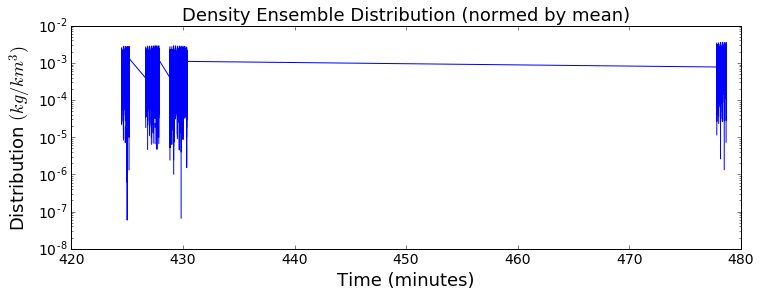

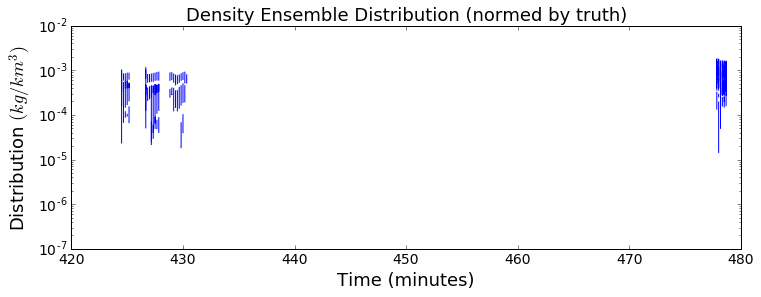

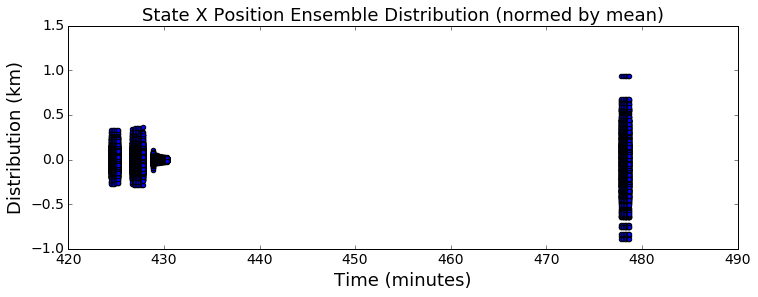

In [66]:
times = measurement_array[:stop_index, 0]/(60)

time_str = 'Time (minutes)'

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)

#"""
#calculate the normed density distribution by subtracting the mean of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_mean = np.mean(density_distribution[:,:stop_index], axis=0).reshape(1, stop_index)

density_distribution_mean_tiled = np.tile(density_distribution_mean, (1, num_of_ensembles))
density_distribution_mean_tiled = density_distribution_mean_tiled.reshape(num_of_ensembles, stop_index)

density_distribution_normed = density_distribution[:, :stop_index] - density_distribution_mean_tiled


fig, ax = plt.subplots()
ax.semilogy(time_repeated_ensemble, density_distribution_normed.T.flatten())
#plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-.5e-3, .5e-3)
plt.title('Density Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed density distribution by subtracting the truth of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
true_density_array = truth_xyz[:,-1]
density_distribution_truth = true_density_array[:stop_index].reshape(1, stop_index)
density_distribution_normed = density_distribution[:, :stop_index] - \
                    np.tile(density_distribution_truth, (num_of_ensembles, 1))

fig_dens_dist, ax = plt.subplots()
ax.semilogy(time_repeated_ensemble, density_distribution_normed.T.flatten())
#plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-3, 1e-3)
plt.title('Density Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()
#"""

#calculate the normed X pos distribution by subtracting the mean of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos = X_distribution[0,:,:stop_index]
X_distribution_Xpos_mean = np.mean(X_distribution_Xpos, axis=0).reshape(1, stop_index)
X_distribution_Xpos_mean_tiled = np.tile(X_distribution_Xpos_mean, (1, num_of_ensembles))
X_distribution_Xpos_mean_tiled = X_distribution_Xpos_mean_tiled.reshape(num_of_ensembles, stop_index)
X_distribution_Xpos_diff = X_distribution_Xpos - X_distribution_Xpos_mean_tiled

fig_X_dist = plt.figure()
plt.scatter(time_repeated_X, X_distribution_Xpos_diff.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4,1e-4)
plt.title('State X Position Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()


''' not normed by correct truth because truth time series is for different objects
#calculate the normed X pos distribution by subtracting the truth of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos_truth = truth_xyz[:stop_index, 0].reshape(1, stop_index)
X_distribution_Xpos_truth_normed = X_distribution_Xpos - np.tile(X_distribution_Xpos_truth, (num_of_ensembles, 1))

fig_X_dist = plt.figure()
plt.scatter(time_repeated_ensemble, X_distribution_Xpos_truth_normed.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4, 1e-4)
plt.title('State X Position Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()
'''


if saveFig_bool:
    fig_dens_dist.savefig('Figures/dens_dist.png')
    fig_X_dist.savefig('Figures/fig_X_dist.png')


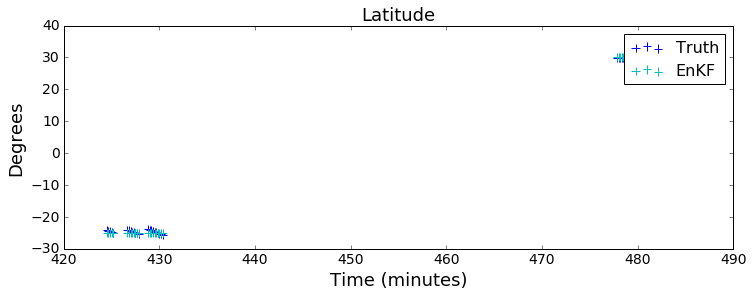

[ 0.894925668385094  0.691032943780489  0.49017024744729   0.292375575312718
  0.097686722002507  1.021616267757617  0.815949071054415
  0.613288927962713  0.413673884182644  0.217141794530664
  0.023730304327913 -0.166523169670217 -0.353581458788744
  1.176477955121818  0.96867013007139   0.763840172358482
  0.562026183446544  0.363266087105301  0.167597611203368
 -0.024941730965478 -0.214314659809383 -0.400484149004085
 -0.583413445480774 -0.287528689665247 -0.243224118404097
 -0.203113028236424 -0.167205864209002 -0.135512029220659
 -0.108039874557248]


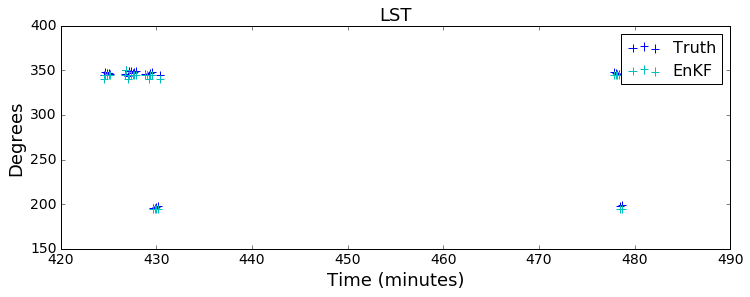

[ 4.659821478311451  3.065473878108147  2.380060599106468
  1.696781087287108  1.015643663813502  0.336655269039771  0.13441197404518
  3.985146525579026  3.753011200626635  4.44266142446832   1.523673755329781
  3.578840409686917  4.26814924540292   0.842902746926319
  0.164286151955902  4.487829203673884  2.206592583564382  2.89165125925817
  0.455467227627018  1.200930858208449  1.947039357052913
  2.693731695960101  4.900603345018347  2.624887335101613
  1.940588612446302  1.258436992389544  0.578439889349525
  3.440946261171085  4.188620917591738]


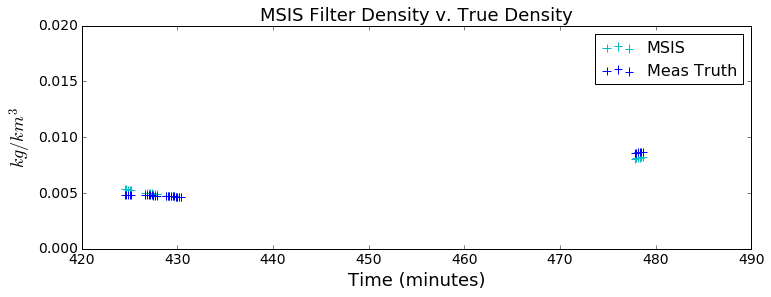

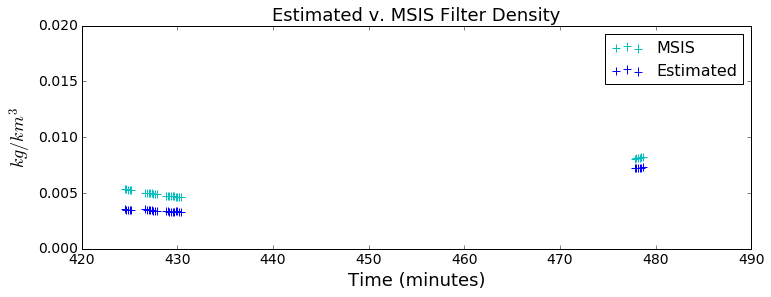

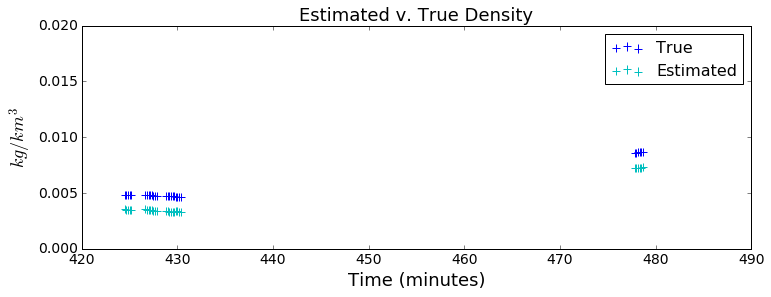

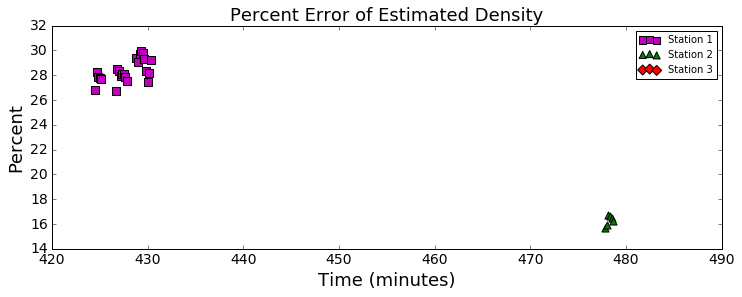

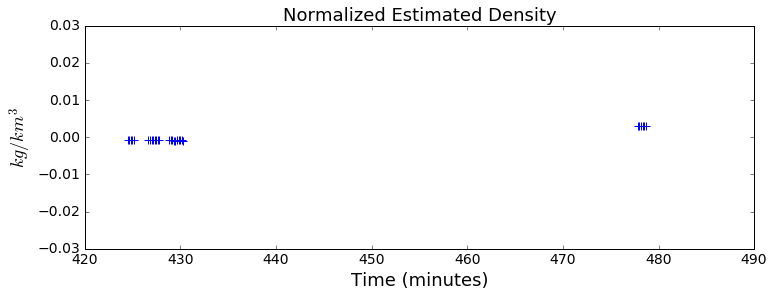

In [67]:


time_str = 'Time (minutes)'


times = measurement_array[:stop_index, 0]/(60)

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)


indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]


#sort by object so that results show all results for one object and then
indices = np.argsort(measurement_array[:stop_index,2], axis=0) 


fig_lat = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 0]), s=70, c='b',marker='+')
plt.scatter(times, np.degrees(lat_lst_array[0,:stop_index]), s=70, c='c',marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Latitude', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()

print(np.degrees(lat_lst_meas_array[:stop_index, 0] - lat_lst_array[0,:stop_index]))



fig_LST = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 1][indices]), s=70, c='b', marker='+')
plt.scatter(times, np.degrees(lat_lst_array[1,:stop_index][indices]), s=70, c='c', marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('LST', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()

print(np.degrees(lat_lst_meas_array[:stop_index, 1][indices] - lat_lst_array[1,:stop_index][indices]))


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-2])
plt.title('MSIS Filter Density v. True Density', fontsize=18)
legend_names = ['MSIS', 'Meas Truth']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, -1], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-2])
plt.title('Estimated v. MSIS Filter Density', fontsize=18)
legend_names = ['MSIS', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()




fig_density_comparison = plt.figure()
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, -1], s=70, c='c', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-2])
plt.title('Estimated v. True Density', fontsize=18)
legend_names = ['True', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()



perc_error = 100 * np.absolute(X_mean_updated_list_EnKF[:stop_index, -1] - true_density_array[:stop_index])/true_density_array[:stop_index]

fig_percent = plt.figure()
plt.scatter(times[indices_1], perc_error[indices_1], s=50, c='m', marker='s')
plt.scatter(times[indices_2], perc_error[indices_2], s=50, c='g', marker='^')
plt.scatter(times[indices_3], perc_error[indices_3], s=50, c='r', marker='D')
plt.scatter(times[indices_4], perc_error[indices_4], s=50, c='k', marker='o')
#plt.ylim([0,200])
plt.ylabel('Percent', fontsize=18)
legend_names = ['Station 1', 'Station 2', 'Station 3']
plt.legend(legend_names, fontsize=10)
plt.xlabel(time_str, fontsize=18)
plt.title('Percent Error of Estimated Density', fontsize=18)
plt.show()



mean = np.mean(X_mean_updated_list_EnKF[:stop_index, -1])
est_density_array_normalized = X_mean_updated_list_EnKF[:stop_index, -1] - mean

fig_est = plt.figure()
plt.scatter(times, est_density_array_normalized[:stop_index], s=70, c='b', marker='+')
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Normalized Estimated Density', fontsize=18)
plt.show()



if saveFig_bool:
    fig_lat.savefig('Figures/latitude.png')
    fig_LST.savefig('Figures/LST.png')
    fig_density_comparison.savefig('Figures/density_comparison.png')
    fig_percent.savefig('Figures/percent.png')
    fig_est.savefig('Figures/est_density.png')


[]
0


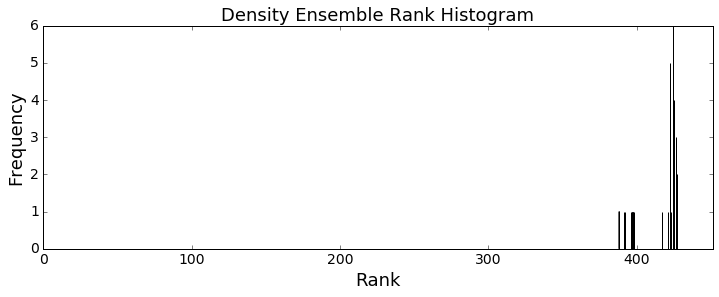

In [51]:
# Rank Histograms


#Density

rank_array = np.zeros((stop_index, 1))

for ii in range(stop_index):
    
    new_array = np.append(density_distribution[:, ii], true_density_array[ii])
    
    rank = scipy.stats.rankdata(new_array, method='min')[-1]
    
    rank_array[ii] = rank
    
indices = np.where(rank_array == 1)[0]
indices1 = np.where(rank_array == 450)[0]
print(times[indices1])
print(len(indices))



fig_rank_hist = plt.figure()
plt.hist(rank_array, bins=451)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Rank', fontsize=18)
plt.title('Density Ensemble Rank Histogram', fontsize=18)
plt.xlim([0,451])
plt.show()

fig_rank_hist.savefig('Figures/rank_hist.png')




In [52]:
rank_array

array([[ 421.],
       [ 425.],
       [ 424.],
       [ 424.],
       [ 424.],
       [ 417.],
       [ 424.],
       [ 424.],
       [ 422.],
       [ 422.],
       [ 422.],
       [ 422.],
       [ 422.],
       [ 426.],
       [ 425.],
       [ 426.],
       [ 427.],
       [ 427.],
       [ 426.],
       [ 424.],
       [ 423.],
       [ 425.],
       [ 425.],
       [ 388.],
       [ 391.],
       [ 398.],
       [ 397.],
       [ 396.],
       [ 392.]])

In [53]:
def calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R, meas_type, stop_index, \
                             saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range pre-fit Residuals'
    save_fig_1 = 'prefit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate pre-fit Residuals'
    save_fig_2 = 'prefit_rangeRate.png'
    pre_fit_list_new = copy.deepcopy(pre_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        pre_fit_list_new[:, 0] = np.degrees(pre_fit_list[:, 0])
        pre_fit_list_new[:, 1] = np.degrees(pre_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth pre-fit Residuals'
        save_fig_1 = 'prefit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation pre-fit Residuals'
        save_fig_2 = 'prefit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]

    
    
    #pre-fit
    print('pre-fit RMS:')
    pre_fit_1_list_4RMS = pre_fit_list_new[:, 0]
    prefit_1_rms = np.sqrt(np.mean(np.square(pre_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % prefit_1_rms, unit_1)

    pre_fit_2_list_4RMS = pre_fit_list_new[:, 1]
    prefit_2_rms = np.sqrt(np.mean(np.square(pre_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % prefit_2_rms, unit_2)
    
    if meas_type == 3:
        pre_fit_3_list_4RMS = pre_fit_list_new[:, 2]
        prefit_3_rms = np.sqrt(np.mean(np.square(pre_fit_3_list_4RMS)))
        print('Range =', "%.3f" % prefit_3_rms, 'km')
    
    
    covar_env_upper1 = np.degrees(abs(prefit_bounds_list[:stop_index, 0]))*3
    covar_env_upper2 = np.degrees(abs(prefit_bounds_list[:stop_index, 1]))*3

   
    #pre-fit Residuals
    fig_preFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2', 'Station 3']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_preFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = abs(prefit_bounds_list[:stop_index, 2])*3
        
        fig_preFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range pre-fit Residuals', fontsize=18)
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('prefit_range.png')
    
    if saveFig_bool:
        fig_preFit_az.savefig('Figures/preFit_az.png')
        fig_preFit_el.savefig('Figures/preFit_el.png')
        fig_preFit_range.savefig('Figures/preFit_range.png')
        
        
def calc_display_results(post_fit_list, measurement_array, R, meas_type, stop_index, saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range Post-fit Residuals'
    save_fig_1 = 'postfit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate Post-fit Residuals'
    save_fig_2 = 'postfit_rangeRate.png'
    post_fit_list_new = copy.deepcopy(post_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        post_fit_list_new[:, 0] = np.degrees(post_fit_list[:, 0])
        post_fit_list_new[:, 1] = np.degrees(post_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth Post-fit Residuals'
        save_fig_1 = 'postfit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation Post-fit Residuals'
        save_fig_2 = 'postfit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]

    
    
    #Post-fit
    print('Post-fit RMS:')
    post_fit_1_list_4RMS = post_fit_list_new[:, 0]
    postfit_1_rms = np.sqrt(np.mean(np.square(post_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % postfit_1_rms, unit_1)

    post_fit_2_list_4RMS = post_fit_list_new[:, 1]
    postfit_2_rms = np.sqrt(np.mean(np.square(post_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % postfit_2_rms, unit_2)
    
    if meas_type == 3:
        post_fit_3_list_4RMS = post_fit_list_new[:, 2]
        postfit_3_rms = np.sqrt(np.mean(np.square(post_fit_3_list_4RMS)))
        print('Range =', "%.5f" % postfit_3_rms, 'km')
    
    
    covar_env_upper1 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[0, 0])))*3
    covar_env_upper2 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[1, 1])))*3

   
    #Post-fit Residuals
    fig_postFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2', 'Station 3']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_postFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = np.ones((stop_index)) * np.sqrt(abs(R[2, 2]))*3
        
        fig_postFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], post_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], post_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], post_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], post_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range Post-fit Residuals', fontsize=18)
        legend_names = ['Station 1', 'Station 2']
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('postfit_range.png')
    
    if saveFig_bool:
        fig_postFit_az.savefig('Figures/postFit_az.png')
        fig_postFit_el.savefig('Figures/postFit_el.png')
        fig_postFit_range.savefig('Figures/postFit_range.png')
        
    
    
def plot_error_covar_xref(P_list, x_ref_updated_list, x_ref_TU_list, obs_data_truth, density_truth, density_range, x_range, y_range, \
                          z_range, xv_range, yv_range, zv_range, measurement_array, time, stop_index, \
                          saveFig_bool, time_str, title_str, num_of_objects):
    
    
    times = time[:stop_index]/(60)
    
    initial_filter_index = initial_sim_index + 1
    
    #prep all times (including no-measurement times) results
    true_all_sim_times = true_state_all_times[(initial_filter_index):(initial_filter_index+TU_array_length),:]
    
    times_all = true_all_sim_times[:,0]/60
    
    density_error_all = x_ref_TU_list[:,-1] - true_all_sim_times[:, -1]

    
    

    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    
    
    
    density_covar_env_upper = np.sqrt(abs(P_list[:stop_index, -1, -1]))*3
    density_covar_env_lower = -density_covar_env_upper
    density_error = x_ref_updated_list[:stop_index,-1] - density_truth[:stop_index]
        
    
    #error_pos_norm = np.sqrt(x_error**2 + y_error**2 + z_error**2)
    error_density_rms_3D = np.sqrt(np.mean(np.square(density_error)))
    print('Density RMS =', "%.5f" % error_density_rms_3D, r'$(kg/km^3)$')
    
    
    #Density
    fig_dens = plt.figure()
    plt.scatter(times_all, density_error_all, label='_nolegend_', s=20, c='k', marker='.')
    plt.plot(times, density_covar_env_upper, label='_nolegend_', c='g')
    plt.plot(times, density_covar_env_lower, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], density_error[indices_1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], density_error[indices_2], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], density_error[indices_3], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], density_error[indices_4], s=50, c='k', marker='o')
    plt.ylabel(r'$(kg/km^3)$', fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    legend_names = ['Station 1', 'Station 2', 'Station 3']
    plt.legend(legend_names, fontsize=10)
    plt.title(title_str + ' Density Error & Covariance Envelope', fontsize=18)
    plt.ylim([-density_range,density_range])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.show()
    
    if saveFig_bool:
            
            fig_dens.savefig('Figures/dens_error.png')
    

    
    
    for ii in range(num_of_objects):
        
        
        
        #based on object ID, calculate indices in the state for this update
        ID = ii + 1
        obj_index_begin = (ID-1)*6
        obj_index_end = ID*6 - 1
        object_num = ID
        
        
        x_pos_index = obj_index_begin
        y_pos_index = obj_index_begin + 1
        z_pos_index = obj_index_begin + 2
        x_vel_index = obj_index_begin + 3 
        y_vel_index = obj_index_begin + 4
        z_vel_index = obj_index_begin + 5
        
        
        #find this object's results
        indices = np.where(true_state_all_times[:,1] == ID)[0]  
        true_state_all_times_thisObj = true_state_all_times[np.r_[indices,:]]
        
        true_all_sim_times_thisObj = true_state_all_times_thisObj\
                            [(initial_filter_index):(initial_filter_index+TU_array_length),:]
        
        times_all = true_state_all_times_thisObj[(initial_filter_index):(initial_filter_index+TU_array_length),0]/60
        

        x_error_all = x_ref_TU_list[:,x_pos_index] - true_all_sim_times_thisObj[:,2]
        y_error_all = x_ref_TU_list[:,y_pos_index] - true_all_sim_times_thisObj[:,3]
        z_error_all = x_ref_TU_list[:,z_pos_index] - true_all_sim_times_thisObj[:,4]
        x_vel_error_all = x_ref_TU_list[:,x_vel_index] - true_all_sim_times_thisObj[:,5]
        y_vel_error_all = x_ref_TU_list[:,y_vel_index] - true_all_sim_times_thisObj[:,6]
        z_vel_error_all = x_ref_TU_list[:,z_vel_index] - true_all_sim_times_thisObj[:,7]
        
        
        
        indices_obj = np.where(measurement_array[:stop_index, 2] == ID)[0]
        
        if len(indices_obj) != 0:
        
            indices_1 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 1)[0]
            indices_2 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 2)[0]
            indices_3 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 3)[0]

            times_obj = times[:stop_index][np.r_[indices_obj]]


            #Compare to the Truth Data : Estimation Errors------

            x_covar_env_upper = np.sqrt(abs(P_list[:stop_index, x_pos_index, x_pos_index]))*3
            x_covar_env_lower = -x_covar_env_upper
            x_error = x_ref_updated_list[:stop_index,x_pos_index][np.r_[indices_obj]] - \
                                obs_data_truth[:stop_index, 0][np.r_[indices_obj]]
        

            y_covar_env_upper = np.sqrt(abs(P_list[:stop_index, y_pos_index, y_pos_index]))*3
            y_covar_env_lower = -y_covar_env_upper
            y_error = x_ref_updated_list[:stop_index,y_pos_index][np.r_[indices_obj]] - \
                                 obs_data_truth[:stop_index, 1][np.r_[indices_obj]]

            z_covar_env_upper = np.sqrt(abs(P_list[:stop_index, z_pos_index, z_pos_index]))*3
            z_covar_env_lower = -z_covar_env_upper
            z_error = x_ref_updated_list[:stop_index,z_pos_index][np.r_[indices_obj]] - \
                                 obs_data_truth[:stop_index, 2][np.r_[indices_obj]]

            

            print('~~Obj ' + str(object_num) + ' Results~~')
            print('Position RMS:')
            error_x_pos_rms_3D = np.sqrt(np.mean(np.square(x_error)))
            print('X =', "%.4f" % error_x_pos_rms_3D, 'km')

            error_y_pos_rms_3D = np.sqrt(np.mean(np.square(y_error)))
            print('Y =', "%.4f" % error_y_pos_rms_3D, 'km')

            error_z_pos_rms_3D = np.sqrt(np.mean(np.square(z_error)))
            print('Z =', "%.4f" % error_z_pos_rms_3D, 'km')

            pos_rms = np.sqrt(error_x_pos_rms_3D**2 + error_y_pos_rms_3D**2 + error_z_pos_rms_3D**2)
            print('Overall =', "%.4f" % pos_rms, 'km')

            #x Velocity
            x_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, x_vel_index, x_vel_index]))*3
            x_dot_covar_env_lower = -x_dot_covar_env_upper
            x_vel_error = x_ref_updated_list[:stop_index,x_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 3][np.r_[indices_obj]]

            #y Velocity
            y_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, y_vel_index, y_vel_index]))*3
            y_dot_covar_env_lower = -y_dot_covar_env_upper
            y_vel_error = x_ref_updated_list[:stop_index,y_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 4][np.r_[indices_obj]]        

            #z Velocity
            z_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, z_vel_index, z_vel_index]))*3
            z_dot_covar_env_lower = -z_dot_covar_env_upper
            z_vel_error = x_ref_updated_list[:stop_index,z_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 5][np.r_[indices_obj]]       

            print('\nVelocity RMS:')
            error_x_vel_rms_3D = np.sqrt(np.mean(np.square(x_vel_error)))
            print('X =', "%.6f" % error_x_vel_rms_3D, 'km/second')

            error_y_vel_rms_3D = np.sqrt(np.mean(np.square(y_vel_error)))
            print('Y =', "%.6f" % error_y_vel_rms_3D, 'km/second')

            error_z_vel_rms_3D = np.sqrt(np.mean(np.square(z_vel_error)))
            print('Z =', "%.6f" % error_z_vel_rms_3D, 'km/second')

            vel_rms = np.sqrt(error_x_vel_rms_3D**2 + error_y_vel_rms_3D**2 + error_z_vel_rms_3D**2)
            print('Overall =', "%.6f" % vel_rms, 'km/s')



            #x Position
            fig_xpos = plt.figure()
            plt.scatter(times_all, x_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, x_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, x_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], x_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], x_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], x_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], x_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' X Position Error & Covariance Envelope', fontsize=18)
            plt.ylim([-x_range,x_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()

            #y Position 
            fig_ypos = plt.figure()
            plt.scatter(times_all, y_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, y_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, y_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], y_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], y_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], y_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], y_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Y Position Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-y_range,y_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()
            #fig.savefig('y_pos_error.png')

            #z Position
            fig_zpos = plt.figure()
            plt.scatter(times_all, z_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, z_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, z_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], z_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], z_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], z_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], z_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Z Position Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-z_range,z_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            fig_xvel = plt.figure()
            plt.scatter(times_all, x_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, x_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, x_dot_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], x_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], x_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], x_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], x_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' X Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-xv_range,xv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()
            #fig.savefig('x_vel_error.png')



            fig_yvel = plt.figure()
            plt.scatter(times_all, y_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, y_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, y_dot_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], y_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], y_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], y_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], y_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Y Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-yv_range,yv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            fig_zvel = plt.figure()
            plt.scatter(times_all, z_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, z_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, z_dot_covar_env_lower, label='_nolegend_', c='g') 
            plt.scatter(times_obj[indices_1], z_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], z_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], z_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], z_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Z Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-zv_range,zv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            if saveFig_bool:

                fig_xpos.savefig('Figures/x_pos_error_obj' + str(object_num) + '.png')
                fig_ypos.savefig('Figures/y_pos_error_obj' + str(object_num) + '.png')
                fig_zpos.savefig('Figures/z_pos_error_obj' + str(object_num) + '.png')
                fig_xvel.savefig('Figures/x_vel_error_obj' + str(object_num) + '.png')
                fig_yvel.savefig('Figures/y_vel_error_obj' + str(object_num) + '.png')
                fig_zvel.savefig('Figures/z_vel_error_obj' + str(object_num) + '.png')



pre-fit RMS:
Azimuth = 0.0023 degrees
Elevation = 0.0037 degrees
Range = 0.008 km


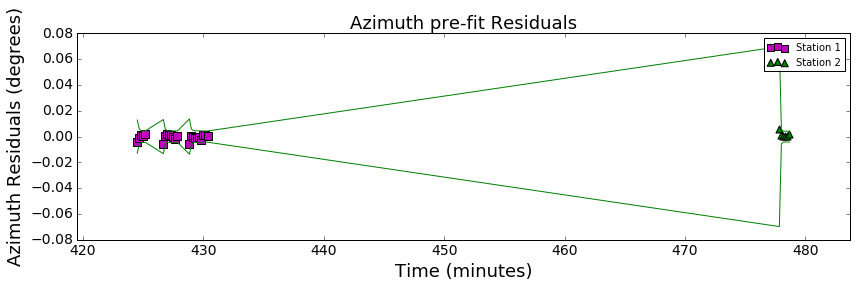

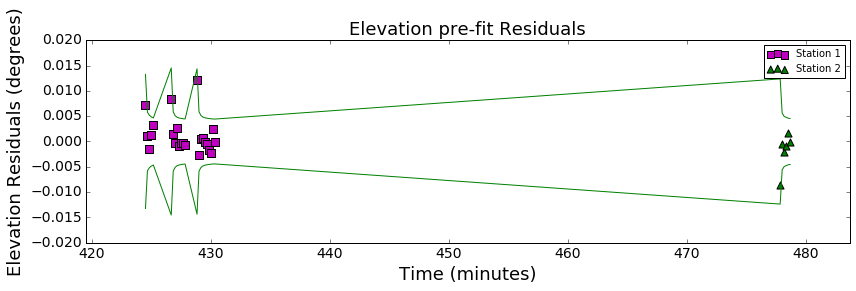

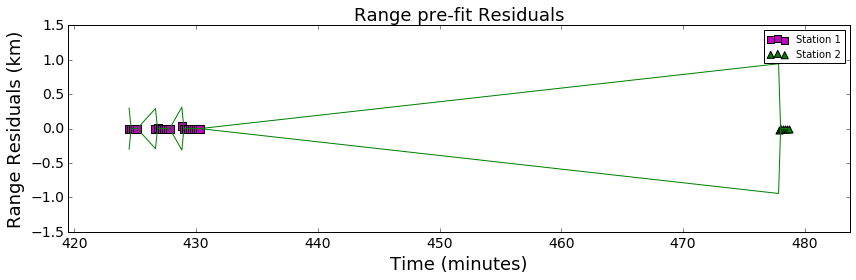

Post-fit RMS:
Azimuth = 0.0011 degrees
Elevation = 0.0011 degrees
Range = 0.00003 km


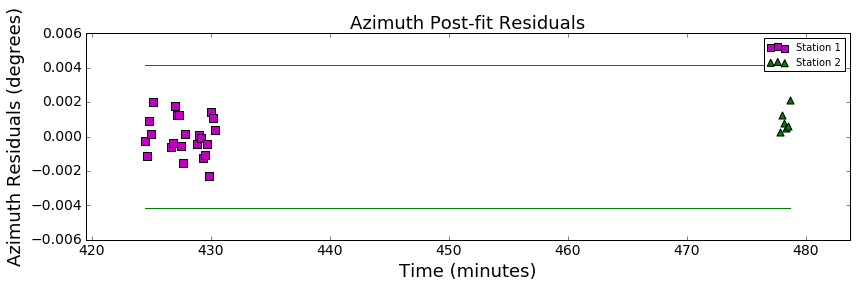

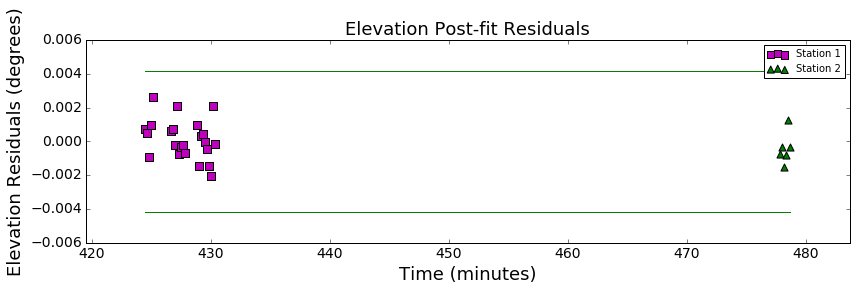

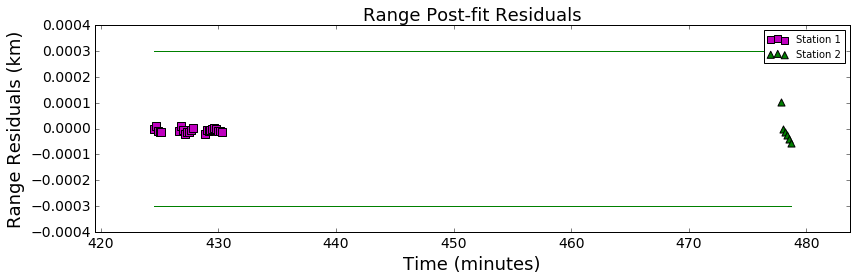

Density RMS = 0.00136 $(kg/km^3)$


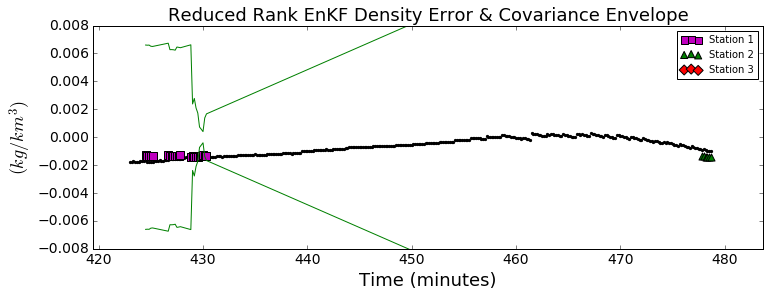

~~Obj 1 Results~~
Position RMS:
X = 0.0141 km
Y = 0.0072 km
Z = 0.0102 km
Overall = 0.0189 km

Velocity RMS:
X = 0.000053 km/second
Y = 0.000020 km/second
Z = 0.000112 km/second
Overall = 0.000126 km/s


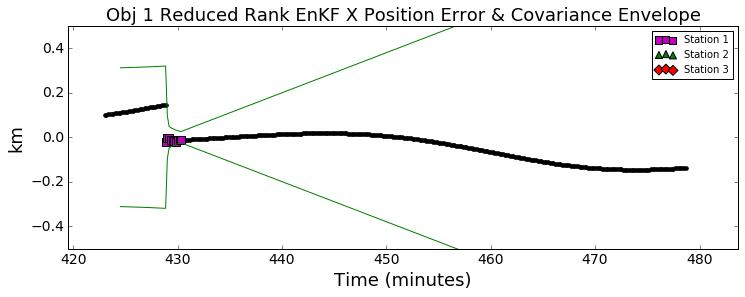

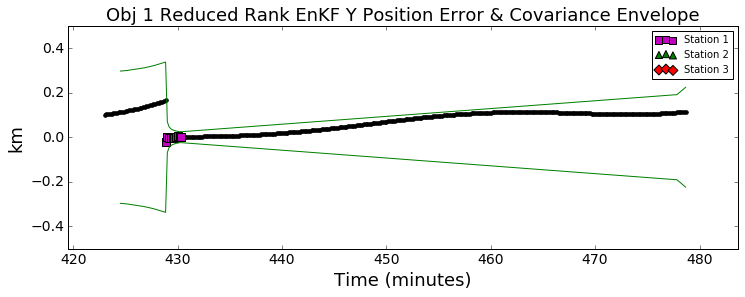

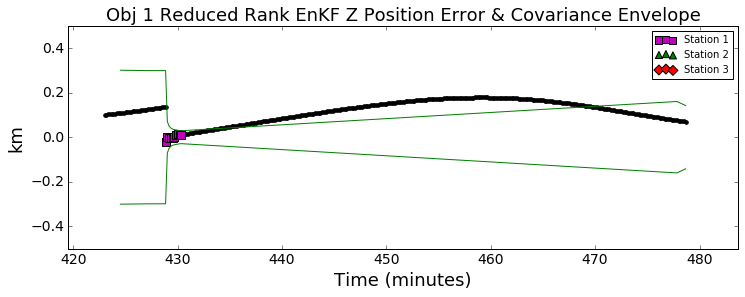

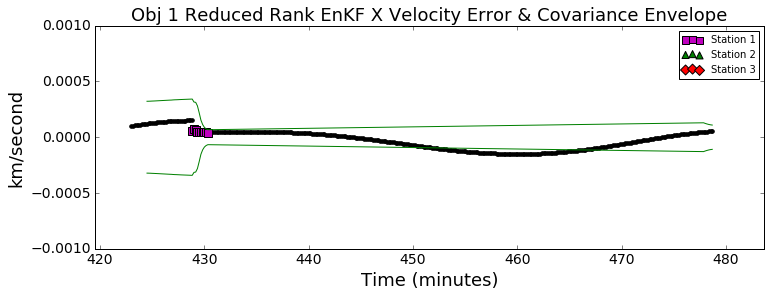

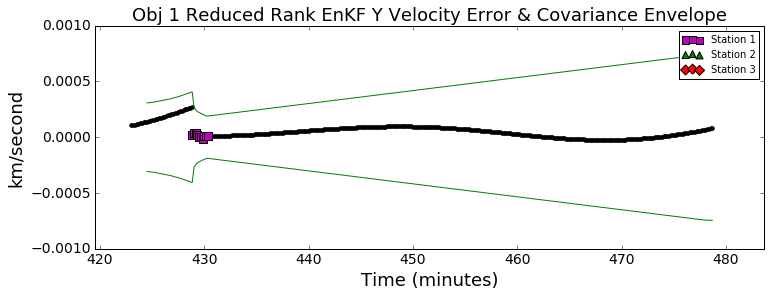

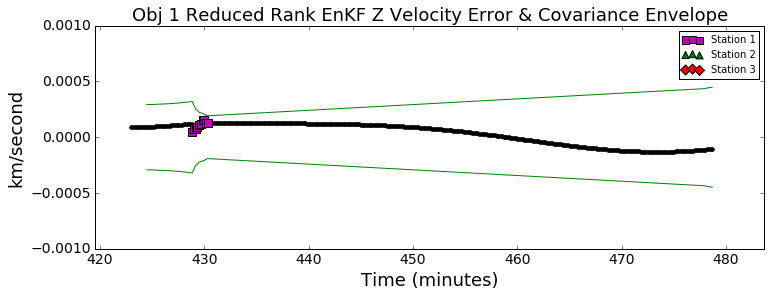

~~Obj 2 Results~~
Position RMS:
X = 0.0114 km
Y = 0.0067 km
Z = 0.0078 km
Overall = 0.0154 km

Velocity RMS:
X = 0.000060 km/second
Y = 0.000084 km/second
Z = 0.000085 km/second
Overall = 0.000134 km/s


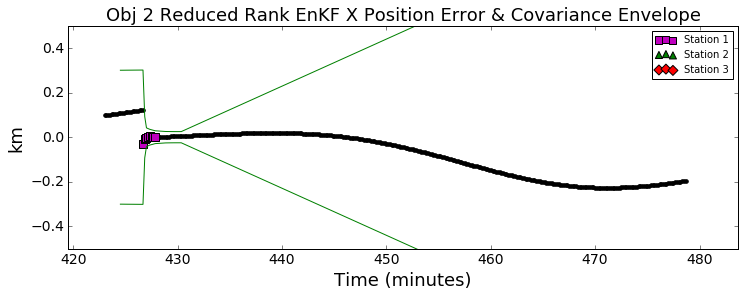

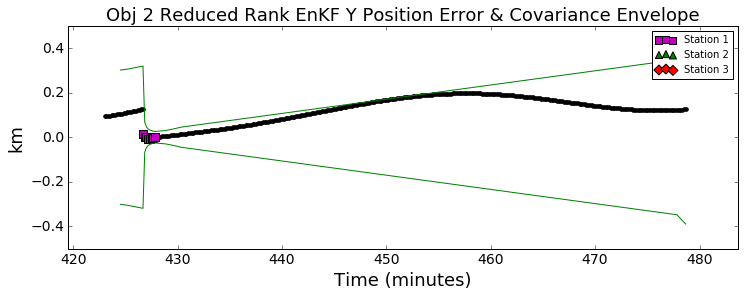

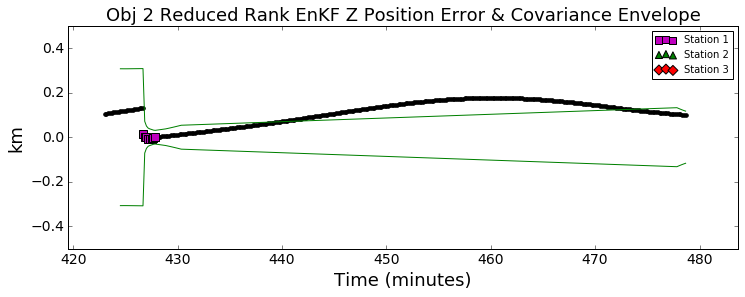

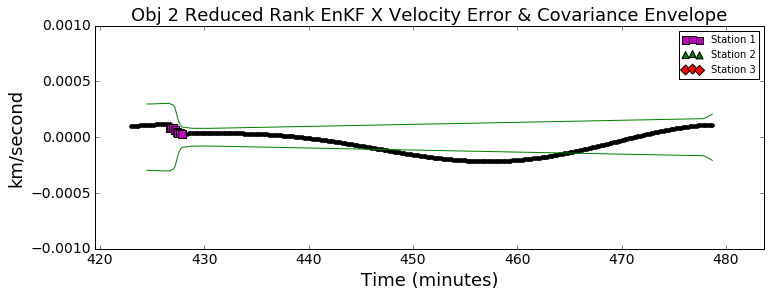

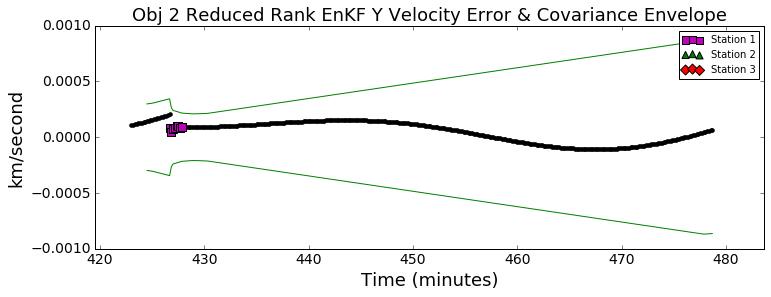

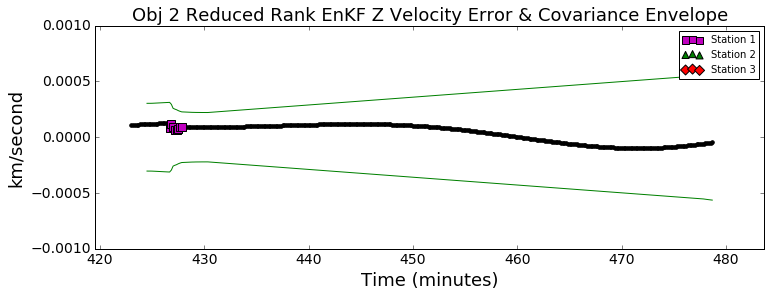

~~Obj 3 Results~~
Position RMS:
X = 0.0032 km
Y = 0.0122 km
Z = 0.0141 km
Overall = 0.0189 km

Velocity RMS:
X = 0.000065 km/second
Y = 0.000051 km/second
Z = 0.000078 km/second
Overall = 0.000114 km/s


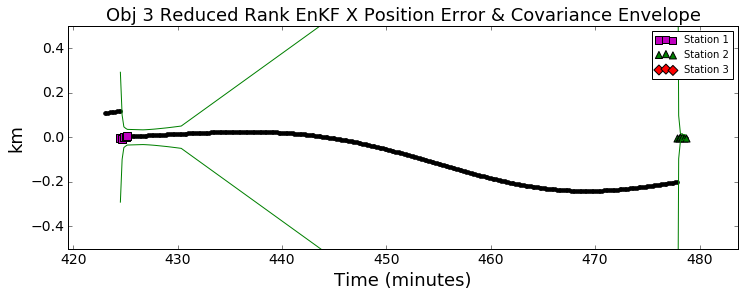

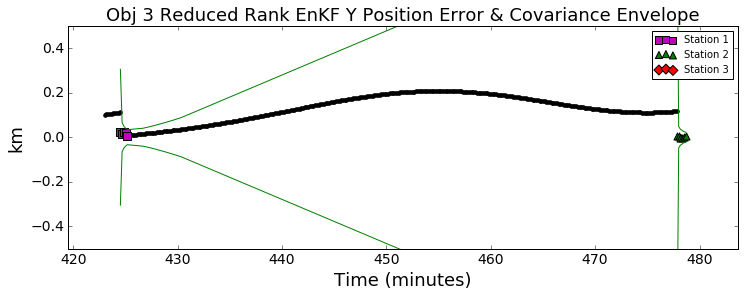

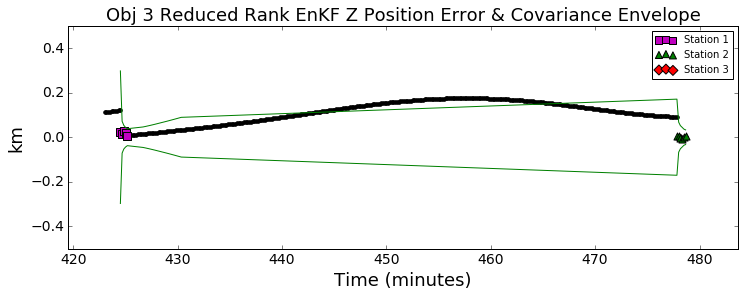

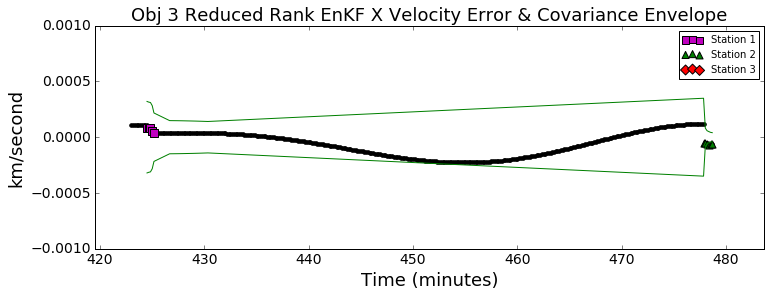

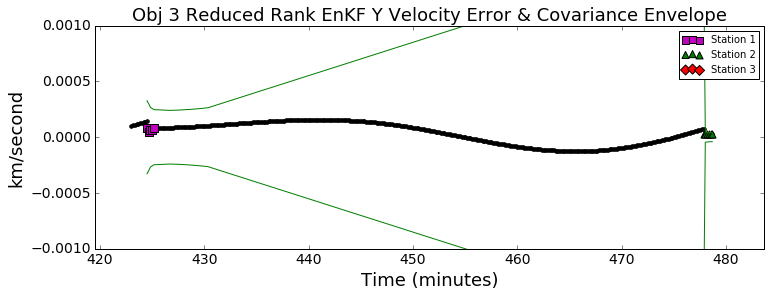

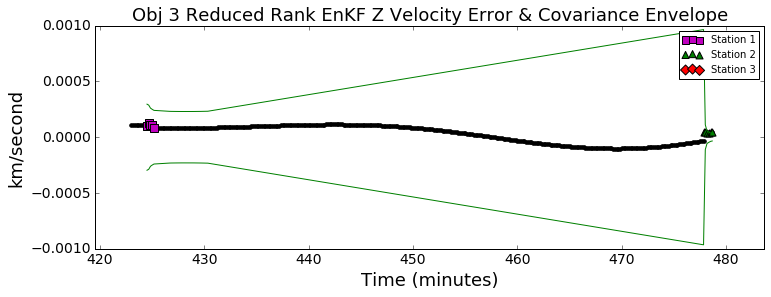

In [58]:

#Generate Plots for Analysis

x_range = .5
y_range = .5
z_range = .5

xv_range = 1e-3
yv_range = 1e-3
zv_range = 1e-3

density_range = 8e-3

times = measurement_array[:, 0]

title_str = 'Reduced Rank EnKF'


filter_functions.calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R,\
                                          meas_type, stop_index, saveFig_bool, time_str)


filter_functions.calc_display_results(post_fit_list_EnKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)


plot_error_covar_xref(P_list_EnKF, X_mean_updated_list_EnKF, X_mean_TU_list_EnKF, truth_xyz, true_density_array, \
                      density_range, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str, title_str, num_of_objects)



In [55]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 46

In [56]:
X_mean_updated_list_EnKF
truth_xyz
ID = 2
indices_obj = np.where(measurement_array[:stop_index, 2] == ID)[0]
indices_2 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 2)[0]
print(indices_obj)
print(indices_2)


print(truth_xyz[:5, 0])
print(X_mean_updated_list_EnKF[:5, 6])


#x_error = x_ref_updated_list[:stop_index,x_pos_index][np.r_[indices_obj]] - \
                            #obs_data_truth[:stop_index, 0][np.r_[indices_obj]]
print(X_mean_updated_list_EnKF[:stop_index,6][np.r_[indices_obj]][:5])
print(truth_xyz[:stop_index, 0][np.r_[indices_obj]][:5])

[ 5  6  7  8  9 10 11 12]
[]
[-1197.975432228844284 -1124.444841062467958 -1050.769240051038196
  -976.958135204372411  -903.021049396777926]
[-2179.015056458700656 -2108.396258698107431 -2037.505423906606893
 -1966.351708206173043 -1894.94430107070707 ]
[-1242.545626620663143 -1169.093836288618604 -1095.503985216817
 -1021.779427856673124  -947.919954703827784]
[-1242.515233053336488 -1169.083972399500681 -1095.501958858547823
 -1021.778686627196862  -947.923667380077745]


In [57]:
initial_sim_index